In [54]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# NEW! for getting summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt

from typing import Optional, Sequence, Tuple, List

# Create Gaussian blurs with different widths

In [2]:
nPerClass = 1000
imgSize   = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# the two widths (a.u.)
widths = [1.8,2.4]

# initialize tensors containing images and labels
images = torch.zeros(2*nPerClass,1,imgSize,imgSize)
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):

  # create the gaussian with random centers
  ro = 2*np.random.randn(2) # ro = random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*widths[i%2]**2) )

  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5

  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
  labels[i] = i%2

labels = labels[:,None]

In [3]:
images.shape

torch.Size([2000, 1, 91, 91])

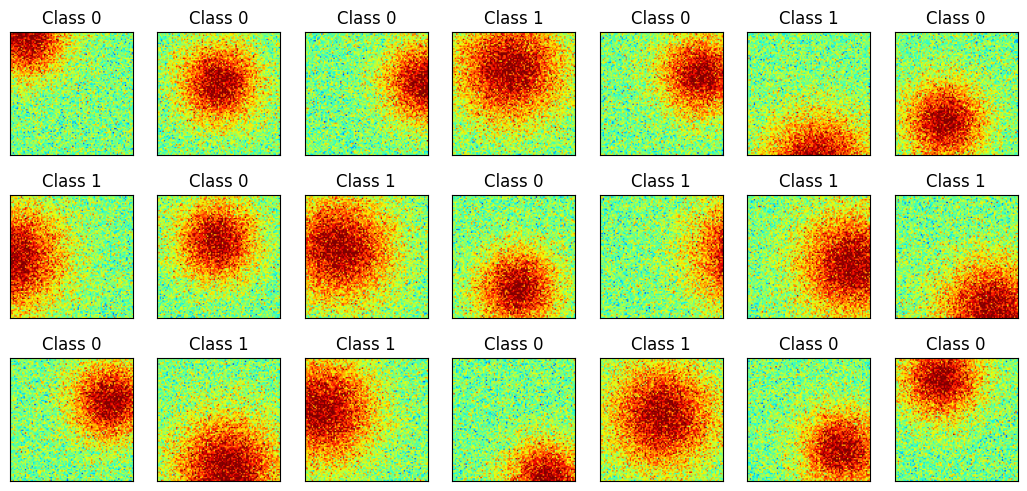

In [4]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(2*nPerClass)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_title('Class %s'%int(labels[whichpic].item()))
  ax.set_xticks([])
  ax.set_yticks([])

plt.show();

# Create train/test groups using DataLoader

In [5]:
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create the DL model

In [6]:
# Helper functions

def _pair(x):
  return x if isinstance(x,(tuple,list)) else (x,x)

def conv2d_out_hw(HW, kernel_size, stride, padding, dilation):
    H, W = HW
    kH, kW = _pair(kernel_size)
    sH, sW = _pair(stride)
    pH, pW = _pair(padding)
    dH, dW = _pair(dilation)
    outH = np.floor((H + 2*pH - dH*(kH-1) - 1)/sH + 1)
    outW = np.floor((W + 2*pW - dW*(kW-1) - 1)/sW + 1)
    return int(outH), int(outW)

In [110]:
class gausnet(nn.Module):
    def __init__(
        self,
        imgSize: Tuple[int, int],           #H,W
        in_channels: int,
        out_channels: Sequence[int],         #conv1, conv2
        kernel_size: int | Tuple[int, int],
        stride: int | Tuple[int, int]=1,
        padding: Optional[int | Tuple[int, int]]=0,
        pool_size: Optional[Tuple[int, int]]=(2,2),
        dilation: int | Tuple[int, int]=1,
        groups: int =1,
        bias: bool =True,
        padding_mode: str='zeros',
        uLinear: Optional[Sequence[int]] = None,
        out_size: int = 1,
        device=None,
        dtype=None,
        print_shapes: bool = False
      ):
      super().__init__()
      assert len(out_channels) >= 2, 'Invalid number of channels'

      factory = dict(device=device, dtype=dtype) # Setting the device and dtype

      self.pool = nn.AvgPool2d(pool_size)

      poolH, poolW = _pair(pool_size)

      # conv1 Layer
      self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels[0],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias,
            padding_mode=padding_mode,
            **factory
        )

      H1, W1 = conv2d_out_hw(imgSize, kernel_size, stride, padding, dilation)
      H1p, W1p = H1 //poolH , W1 // poolW  # avg pool


      # conv2 Layer
      self.conv2 = nn.Conv2d(
            in_channels=out_channels[0],
            out_channels=out_channels[1],
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias,
            padding_mode=padding_mode,
            **factory
        )

      H2, W2 = conv2d_out_hw((H1p,W1p), kernel_size, stride, padding, dilation)
      H2p, W2p = H2 // poolH, W2 // poolW  # avg pool

      flat = int(self.conv2.out_channels * H2p * W2p)
      if flat <= 0: raise ValueError(f"Flattened size {flat} is non-positive. Check imgSize/conv params.")

      # --- Multi-Layer Perceptorn (MLP) (variable depth) ---
      sizes = list(uLinear) if uLinear is not None else [50]
      self.fcs = nn.ModuleList()
      prev = flat
      for h in sizes:
          self.fcs.append(nn.Linear(prev, h, **factory))
          prev = h
      self.output_layer = nn.Linear(prev, out_size, **factory)

      # ----- optional shape printout & probe -----
      if print_shapes:
          C0 = in_channels
          C1 = self.conv1.out_channels
          C2 = self.conv2.out_channels
          print("[gausnet] (math) shapes:")
          print(f"  Input      : (C,H,W)=({C0},{imgSize[0]},{imgSize[1]})")
          print(f"  Conv1 out  : (C,H,W)=({C1},{H1},{W1})")
          print(f"  Pool1 out  : (C,H,W)=({C1},{H1p},{W1p})")
          print(f"  Conv2 out  : (C,H,W)=({C2},{H2},{W2})")
          print(f"  Pool2 out  : (C,H,W)=({C2},{H2p},{W2p})")
          print(f"  Flatten    : {flat}")
          print(f"  MLP sizes  : {sizes} -> out_size={out_size}")

            # Probe with a dummy forward to verify
          with torch.no_grad():
              dummy = torch.zeros(1, C0, imgSize[0], imgSize[1], device=device, dtype=dtype)
              a1 = F.relu(self.conv1(dummy))
              p1 = self.pool(a1)
              a2 = F.relu(self.conv2(p1))
              p2 = self.pool(a2)
              probe_flat = p2.flatten(1).shape[1]

          print("[gausnet] (probe) shapes:")
          print(f"  Conv1 out  : {tuple(a1.shape[1:])}")
          print(f"  Pool1 out  : {tuple(p1.shape[1:])}")
          print(f"  Conv2 out  : {tuple(a2.shape[1:])}")
          print(f"  Pool2 out  : {tuple(p2.shape[1:])}")
          print(f"  Flatten    : {probe_flat}")
          if probe_flat != flat:
              print("[gausnet][WARN] math(flat) != probe(flat) → check conv/pool params!")


    def forward(self,x):
      # first conv-pool set
      conv1act = F.relu(self.conv1(x))
      x = self.pool(conv1act)

      # second conv-pool set
      conv2act = F.relu(self.conv2(x))
      x = self.pool(conv2act)

      # ANN part
      x = x.reshape(x.shape[0],-1)
      for fc in self.fcs:
            x = F.relu(fc(x))
      logits = self.output_layer(x)

      return logits, conv1act, conv2act

In [111]:
def makeTheNet(
    imgSize: Tuple[int, int],
    in_channels: int,
    out_channels: Sequence[int],
    kernel_size: int | Tuple[int, int],
    stride: int | Tuple[int, int] = 1,
    padding: int | Tuple[int, int] = 0,
    pool_size: Optional[Tuple[int,int]] = (2,2),
    dilation: int | Tuple[int, int] = 1,
    groups: int = 1,
    bias: bool = True,
    padding_mode: str = 'zeros',
    uLinear: Optional[Sequence[int]] = None,
    out_size: int = 1,
    device=None,
    dtype=None,
    print_shapes: bool = False
):
    net = gausnet(
        imgSize=imgSize,
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=padding,
        pool_size=pool_size, # Changed from pool=pool
        dilation=dilation,
        groups=groups,
        bias=bias,
        padding_mode=padding_mode,
        uLinear=uLinear,
        out_size=out_size,
        device=device,
        dtype=dtype,
        print_shapes=print_shapes
    )
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    return net, lossfun, optimizer

In [112]:
# count the total number of parameters in the model
net,lossfun,optimizer = makeTheNet(
    imgSize=(images.shape[2],images.shape[3]),
    in_channels=1,
    out_channels=[16,32],
    kernel_size=3,
    stride=1,
    padding=0,
    pool_size=(2,2),
    uLinear=[50],
    out_size=1
)
summary(net,(images.shape[1],images.shape[2],images.shape[3]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 89, 89]             160
         AvgPool2d-2           [-1, 16, 44, 44]               0
            Conv2d-3           [-1, 32, 42, 42]           4,640
         AvgPool2d-4           [-1, 32, 21, 21]               0
            Linear-5                   [-1, 50]         705,650
            Linear-6                    [-1, 1]              51
Total params: 710,501
Trainable params: 710,501
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.74
Params size (MB): 2.71
Estimated Total Size (MB): 4.48
----------------------------------------------------------------


# Train the model

In [113]:
def trainCNNmodel(
    numepochs=10,
    imgSize=(images.shape[2],images.shape[3]),
    in_channels=1,
    out_channels=[16,32],
    kernel_size = 3,
    stride = 1,
    padding = 0,
    pool_size = (2,2),
    uLinear = [50],
    out_size = 1,
    print_shapes = False
):
  net, lossfun, optimizer = makeTheNet(
      imgSize=imgSize,
      in_channels=in_channels,
      out_channels=out_channels,
      kernel_size = kernel_size,
      stride = stride,
      padding = padding,
      pool_size=pool_size,
      uLinear=uLinear,
      out_size=out_size,
      print_shapes=print_shapes
  )

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  testAcc   = torch.zeros(numepochs)

  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)[0] # we only need the first output
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean(( (yHat>0) ==y).float()).item() )
    # end of batch loop...

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)[0] # we only need the first output
      loss = lossfun(yHat,y)

    # compare the following really long line of code to the training accuracy lines
    testLoss[epochi] = loss.item()
    testAcc[epochi]  = 100*torch.mean(( (yHat>0) ==y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainAcc,testAcc,net

# Run the model

In [114]:
feature_maps = (3,6)
kernel_size = (3,2)
stride = (2,3)

trainLoss,testLoss,trainAcc,testAcc,net = trainCNNmodel(
    numepochs=10,
    imgSize=(images.shape[2],images.shape[3]),
    in_channels=1,
    out_channels=feature_maps,
    kernel_size = kernel_size,
    stride = stride,
    uLinear=[50],
    out_size=1,
    print_shapes=False
)

# Visualize the Results

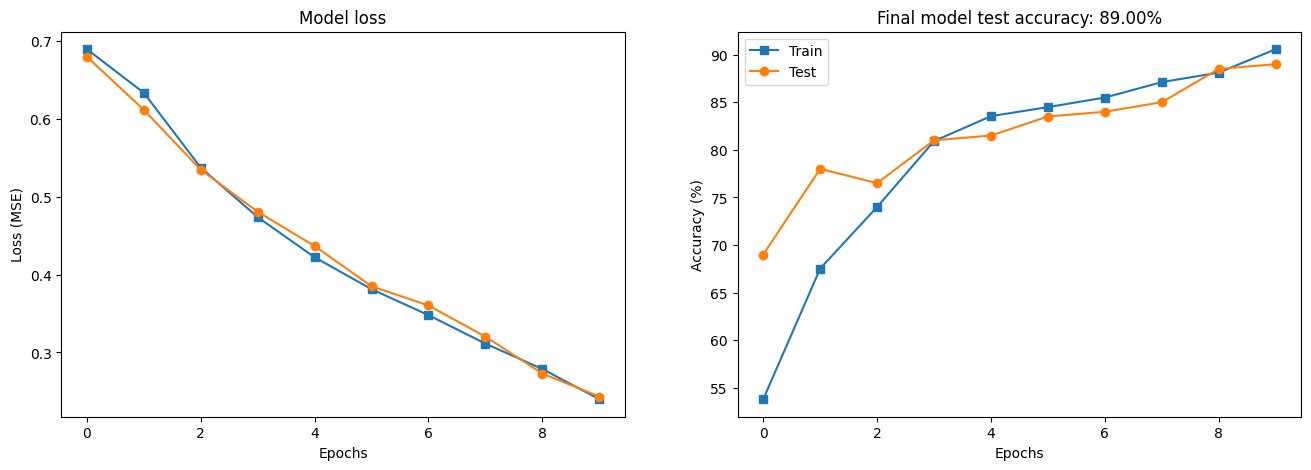

In [115]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show();

# Visualize Some images

[gausnet] (math) shapes:
  Input      : (C,H,W)=(1,91,91)
  Conv1 out  : (C,H,W)=(3,45,30)
  Pool1 out  : (C,H,W)=(3,22,15)
  Conv2 out  : (C,H,W)=(6,10,5)
  Pool2 out  : (C,H,W)=(6,5,2)
  Flatten    : 60
  MLP sizes  : [50] -> out_size=1
[gausnet] (probe) shapes:
  Conv1 out  : (3, 45, 30)
  Pool1 out  : (3, 22, 15)
  Conv2 out  : (6, 10, 5)
  Pool2 out  : (6, 5, 2)
  Flatten    : 60


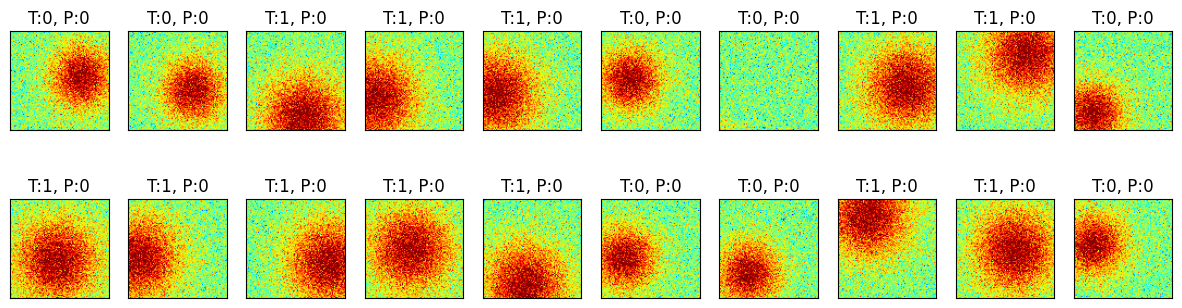

In [116]:
# visualize some images

X,y = next(iter(test_loader)) # extract X,y from test dataloader
net,_,_ = makeTheNet(
    imgSize=(images.shape[2],images.shape[3]),
    in_channels=1,
    out_channels=feature_maps,
    kernel_size = kernel_size,
    stride = stride,
    print_shapes=True
)
yHat,featmap1,featmap2 = net(X)

fig,axs = plt.subplots(2,10,figsize=(15,4))

for i,ax in enumerate(axs.flatten()):
  G = torch.squeeze( X[i,0,:,:] ).detach()
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  t = ( int(y[i].item()) , int(yHat[i].item()>0.5) )
  ax.set_title('T:%s, P:%s'%t)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show();

# Draw the feature maps

In [104]:
featmap1.shape

torch.Size([200, 3, 45, 30])

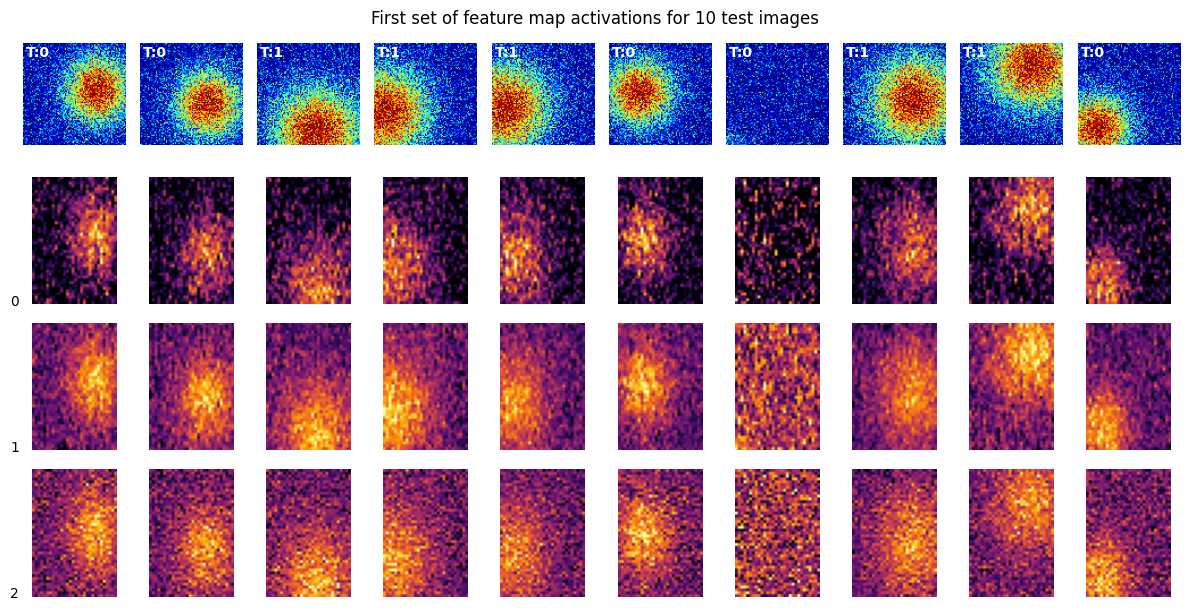

In [105]:
# Feature maps from the conv1 layer

fig,axs = plt.subplots(feature_maps[0]+1,10,figsize=(12,6))

for pici in range(10):

  # show the original picture
  img = X[pici,0,:,:].detach()
  axs[0,pici].imshow(img,cmap='jet',vmin=0,vmax=1)
  axs[0,pici].axis('off')
  axs[0,pici].text(2,2,'T:%s'%int(y[pici].item()),ha='left',va='top',color='w',fontweight='bold')

  for feati in range(feature_maps[0]):
    # extract the feature map from this image
    img = featmap1[pici,feati,:,:].detach()
    axs[feati+1,pici].imshow(img,cmap='inferno',vmin=0,vmax=torch.max(img)*.9)
    axs[feati+1,pici].axis('off')
    axs[feati+1,pici].text(-5,45,feati,ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle('First set of feature map activations for 10 test images',x=.5,y=1.01)
plt.show();

/tmp/ipython-input-4153743582.py:19: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


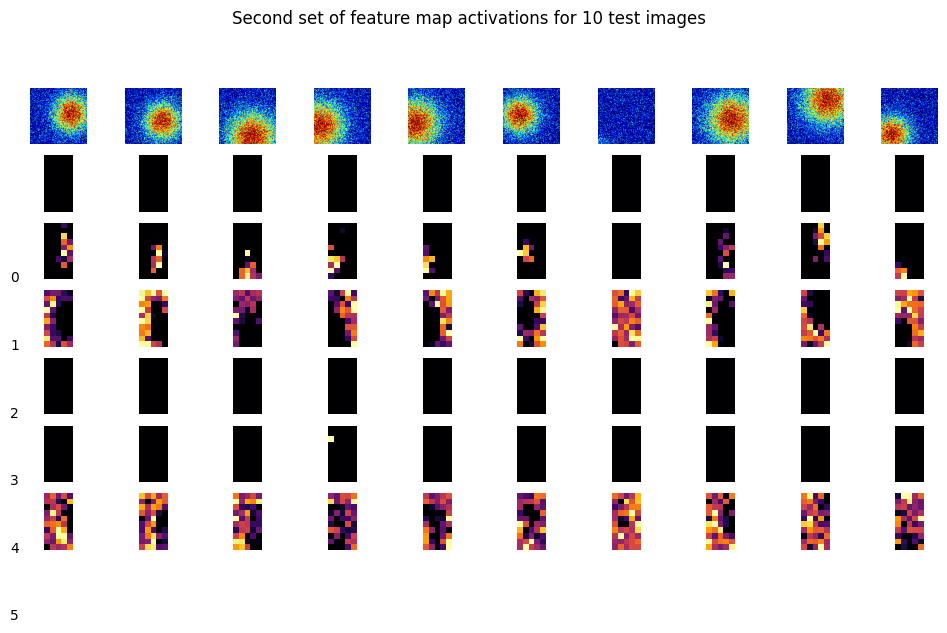

In [106]:
# Repeat for feature2 maps

fig,axs = plt.subplots(feature_maps[1]+1,10,figsize=(12,6))

for pici in range(10):

  # show the original picture
  img = X[pici,0,:,:].detach()
  axs[0,pici].imshow(img,cmap='jet',vmin=0,vmax=1)
  axs[0,pici].axis('off')

  for feati in range(feature_maps[1]):
    # extract the feature map from this image
    img = featmap2[pici,feati,:,:].detach()
    axs[feati+1,pici].imshow(img,cmap='inferno',vmin=0,vmax=torch.max(img)*.9)
    axs[feati+1,pici].axis('off')
    axs[feati+1,pici].text(-5,22,feati,ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle('Second set of feature map activations for 10 test images',x=.5,y=1.01)
plt.show();

# Spatial correlations across the feature maps

In [107]:
featmap2.shape

torch.Size([200, 6, 10, 5])

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipython-input-2372779804.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


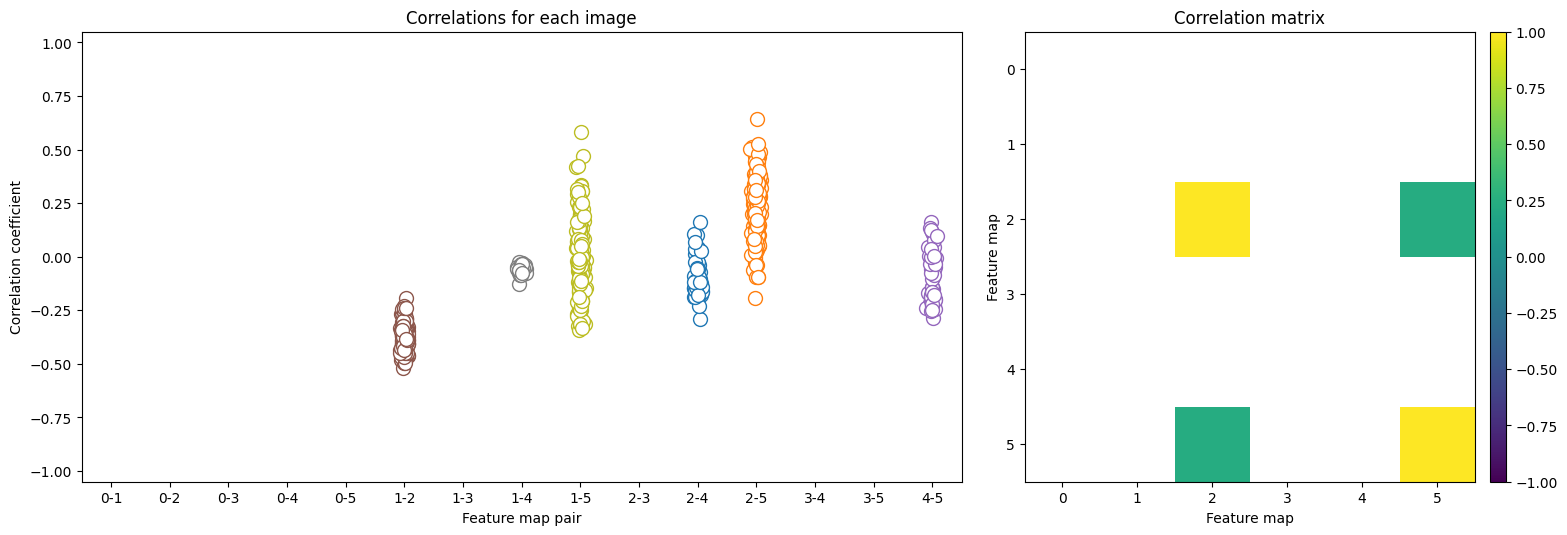

In [108]:
### correlations across the SECOND convolution layer

# convenient variables
nStim = featmap2.shape[0]
nMaps = featmap2.shape[1]
nCors = (nMaps*(nMaps-1))//2

# initialze the matrix of all correlation values
allrs = np.zeros((nStim,nCors))
Call  = np.zeros((nMaps,nMaps))

# loop over each stimulus
for i in range(nStim):

  # extract the vectorized feature maps from this image
  featmaps = featmap2[i,:,:,:].view(nMaps,-1).detach()

  # compute the correlation matrix
  C = np.corrcoef(featmaps)
  Call += C

  # extract the unique correlations from the matrix
  idx = np.nonzero(np.triu(C,1))
  allrs[i,:] = C[idx]


# define the x-axis labels
xlab = []*nCors
for i in range(nCors):
  xlab.append('%s-%s' %(idx[0][i],idx[1][i]))




# now visualize the correlations
fig = plt.figure(figsize=(16,5))
ax0 = fig.add_axes([.1,.1,.55,.9]) # [left, bottom, width, height]
ax1 = fig.add_axes([.68,.1,.3,.9])
cax = fig.add_axes([.98,.1,.01,.9])

for i in range(nCors):
  ax0.plot(i+np.random.randn(nStim)/30,allrs[:,i],'o',markerfacecolor='w',markersize=10)

# make the plot more interpretable
ax0.set_xlim([-.5,nCors-.5])
ax0.set_ylim([-1.05,1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')


# now show the average correlation matrix
h = ax1.imshow(Call/nStim,vmin=-1,vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature map')
ax1.set_ylabel('Feature map')
# add a colorbar
fig.colorbar(h,cax=cax)

plt.tight_layout()
plt.show();

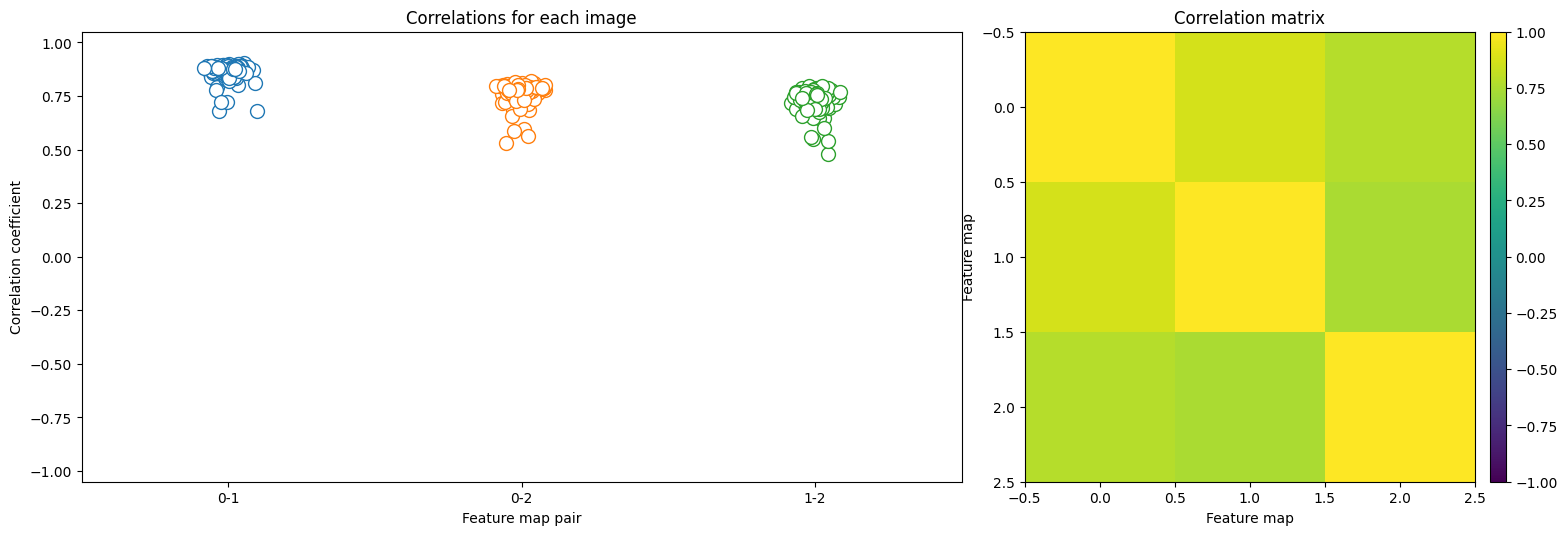

In [109]:
### correlations across the FIRST convolution layer

# convenient variables
nStim = featmap1.shape[0]
nMaps = featmap1.shape[1]
nCors = (nMaps*(nMaps-1))//2

# initialze the matrix of all correlation values
allrs = np.zeros((nStim,nCors))
Call  = np.zeros((nMaps,nMaps))

# loop over each stimulus
for i in range(nStim):

  # extract the vectorized feature maps from this image
  featmaps = featmap1[i,:,:,:].view(nMaps,-1).detach()

  # compute the correlation matrix
  C = np.corrcoef(featmaps)
  Call += C

  # extract the unique correlations from the matrix
  idx = np.nonzero(np.triu(C,1))
  allrs[i,:] = C[idx]


# define the x-axis labels
xlab = []*nCors
for i in range(nCors):
  xlab.append('%s-%s' %(idx[0][i],idx[1][i]))




# now visualize the correlations
fig = plt.figure(figsize=(16,5))
ax0 = fig.add_axes([.1,.1,.55,.9]) # [left, bottom, width, height]
ax1 = fig.add_axes([.68,.1,.3,.9])
cax = fig.add_axes([.98,.1,.01,.9])

for i in range(nCors):
  ax0.plot(i+np.random.randn(nStim)/30,allrs[:,i],'o',markerfacecolor='w',markersize=10)

# make the plot more interpretable
ax0.set_xlim([-.5,nCors-.5])
ax0.set_ylim([-1.05,1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')


# now show the average correlation matrix
h = ax1.imshow(Call/nStim,vmin=-1,vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature map')
ax1.set_ylabel('Feature map')
# add a colorbar
fig.colorbar(h,cax=cax)

plt.show();